## Task
The objective of the project is to learn how to implement a simple image classification pipeline based on the k-Nearest Neighbour and a deep neural network. The goals of this assignment are as follows:
- Understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)
- Data fetching and understand the train/val/test splits.
- Implement and apply an optimal k-Nearest Neighbor (kNN) classifier
- Print the classification metric report
- Implement and apply a deep neural network classifier including (feedforward neural network, RELU activations)
- Understand and be able to implement (vectorized) backpropagation (cost stochastic gradient descent, cross entropy loss, cost functions)
- Implement batch normalization for training the neural network
- Understand the differences and trade-offs between traditional and NN classifiers with the help of classification metrics

#### Import Libraries

In [1]:
import h5py
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dense
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from datetime import datetime
from scipy.stats import randint as sp_randint
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os
from ann_visualizer.visualize import ann_viz
from IPython.display import display, Image
from random import shuffle

Using TensorFlow backend.


Open the file as readonly:

In [2]:
h5f = h5py.File('SVHN_single_grey1.h5', 'r')

Load the training and test set:

In [3]:
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

Close this file:

In [4]:
h5f.close()

Visualizing the first 15 images in the dataset and their labels:

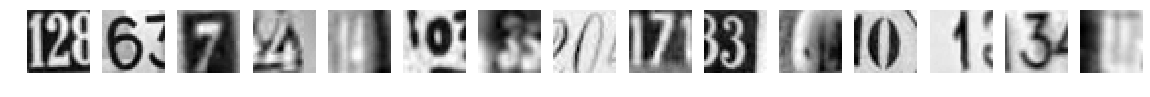

label for each of the above image: [2 6 7 4 4 0 3 0 7 3 1 0 1 3 1]


In [5]:
np.random.seed(1) # fix random seed for reproducibility
plt.figure(figsize=(20, 3))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:15]))

The data contians noise, especially on the right and left sides of the images. I can manually remove part of it by keeping only the data in the middle of the picture.

In the following approch, I decided to remove 25% of the image from each side, keeping only the middle 50% pixels. Hopefully, this approach will improve the performance (by reducing noise) and computational time (by removing 50% of the data to analyze).

In [6]:
noise = 0.25

X_train = X_train[:,1:32-1,int(noise*32):32-int(noise*32)]
X_test = X_test[:,1:32-1,int(noise*32):32-int(noise*32)]

Checking again the first 15 images:

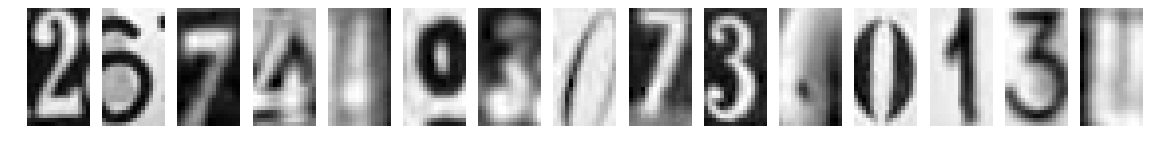

label for each of the above image: [2 6 7 4 4 0 3 0 7 3 1 0 1 3 1]


In [7]:
np.random.seed(1) # fix random seed for reproducibility
plt.figure(figsize=(20, 3))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:15]))

Reshaping the data:

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

Normalize inputs from 0-255 to 0-1 to be used with the ANN:

In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Crate the desired format of the Target:

In [10]:
y_train_to_categorical = np_utils.to_categorical(y_train)
y_test_to_categorical = np_utils.to_categorical(y_test)
y_test_to_categorical

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

Crate the desired structure of the X:

In [11]:
X_train_flatten = []
for i in range(42000):
    X_train_flatten.append(X_train[i,:].flatten())
X_train = np.array(X_train_flatten)  

X_test_flatten = []
for i in range(18000):
    X_test_flatten.append(X_test[i,:].flatten())
X_test = np.array(X_test_flatten)  

Create a sample to be used during hyperparameters tuning:

In [12]:
X_train_sample = X_train[:2000]
y_train_sample = y_train[0:2000]

#### Randomized search with cross-validation in hyperparameters tuning:

Instead of using grid search, I am going to use RandomizedSearchCV. It allows me to have much more control on the time spent on the tuning and usually it leads to better results.

In [13]:
def tuning(model,parameters,iteration=50,n_folds=10,X=X_train,y=y_train,scorer=make_scorer(accuracy_score), estimation=True):
    """
    Return the best combination of hyperparameters
    model: model to tune
    parameters: grid of hyperparameters
    iteration: number of combinations to try randomly
    n_fold: number of folds used in the cross-validation
    score: specify what is the score/target of the problem
    estimation: after 5 loops, it prints the expected execution time
    """
    
    if estimation==True:
        start1=datetime.now()
        randomCV1 = RandomizedSearchCV(model,
                                       param_distributions=parameters,
                                       n_iter=5,
                                       cv=n_folds,
                                       random_state=1)
        randomCV1.fit(X, y)
        stop1=datetime.now()
        execution_time1 = stop1-start1
        print('Expected execution time is about',iteration*execution_time1/5,'\n')
    
    start=datetime.now()
    randomCV = RandomizedSearchCV(model,
                                  param_distributions=parameters,
                                  n_iter=iteration,
                                  cv=n_folds,
                                  scoring=scorer,
                                  random_state=1)
    randomCV.fit(X, y)
    stop=datetime.now()
    execution_time = stop-start
    print('Execution time =',execution_time,'\n')
    print('\nTHE BEST COMBINATION OF HYPERPARAMETERS IS:\n\n',randomCV.best_params_)

#### kNN

In [65]:
param_dist = {'n_neighbors': list(filter(lambda x: x % 2 != 0, list(range(3,50))))}

tuning(KNeighborsClassifier(), param_dist, X=X_train_sample, y=y_train_sample)

Expected execution time is about 0:22:43.355130 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Execution time = 0:10:07.155402 


THE BEST COMBINATION OF HYPERPARAMETERS IS:

 {'n_neighbors': 5}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Saving kNN hyperparameters:

In [14]:
knn_hyperparameters = {'n_neighbors': 5}

knn = KNeighborsClassifier(n_neighbors=knn_hyperparameters.get('n_neighbors'))

Defining a function to evaluate the model:

In [15]:
def model_evaluation(model):  
    
    if model == knn or model == lgbm:
        start_training=datetime.now()
        model.fit(X_train, y_train)
        stop_training=datetime.now()
        execution_time_training = (stop_training-start_training).total_seconds()
        y_pred = model.predict(X_test)
        stop_testing=datetime.now()
        execution_time_training = (stop_training-start_training).total_seconds()
        execution_time_testing = (stop_testing-stop_training).total_seconds()
        print('TRAINING execution time =',round((execution_time_training),0),'seconds')
        print('TESTING execution time =',round((execution_time_testing),0),'seconds\n')
        
    else:
        start_testing=datetime.now()
        y_pred = model.predict_classes(X_test)
        stop_testing=datetime.now()
        execution_time_testing = (stop_testing-start_testing).total_seconds()
        print('TRAINING execution time =',round((execution_time_training_ANN),0),'seconds')
        print('TESTING execution time =',round((execution_time_testing),0),'seconds\n')
          
    print(classification_report(y_test, y_pred))
    a = round(metrics.accuracy_score(y_test, y_pred),3)
    print('\n\nACCURACY =',round((a*100),2),'%')
    cm = confusion_matrix(y_test, y_pred)
    cm = cm/cm.sum()
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, 
                annot=True,  
                fmt='.1%',
                annot_kws={'size': 10},
                xticklabels=['9','8','7','6','5','4','3','2','1','0'] , 
                yticklabels=['9','8','7','6','5','4','3','2','1','0'], 
                linewidths=0.1, 
                linecolor='white',
                cmap='YlGnBu')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

kNN model evaluation:

TRAINING execution time = 3.0 seconds
TESTING execution time = 779.0 seconds

              precision    recall  f1-score   support

           0       0.55      0.79      0.65      1814
           1       0.55      0.85      0.67      1828
           2       0.81      0.72      0.76      1803
           3       0.69      0.62      0.66      1719
           4       0.80      0.78      0.79      1812
           5       0.74      0.61      0.67      1768
           6       0.70      0.62      0.65      1832
           7       0.82      0.75      0.78      1808
           8       0.69      0.58      0.63      1812
           9       0.78      0.61      0.69      1804

   micro avg       0.69      0.69      0.69     18000
   macro avg       0.71      0.69      0.69     18000
weighted avg       0.71      0.69      0.69     18000



ACCURACY = 69.3 %


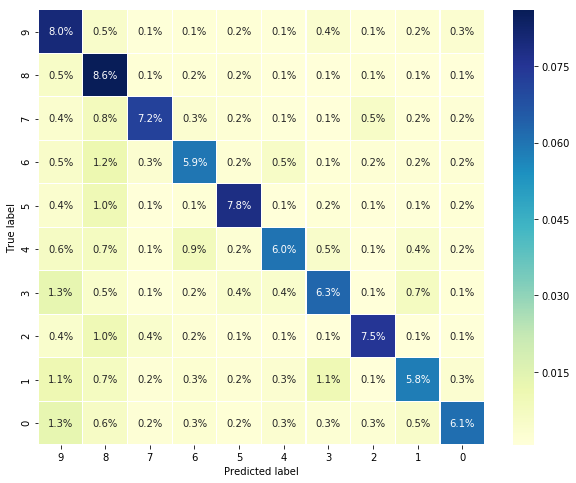

In [16]:
model_evaluation(knn)

Considering that the accuracy for a random model is 10%, kNN doens't work so bad (69.3% accuracy). The real problem is that is very slow in testing.

kNN is a very simple model, which has been used in a very difficult task. I could also try to use a more sophisticated model:

#### Light GBM

In [17]:
param_dist = {'application': ['binary'],
              'objective': ['binary'],
              'feature_fraction': np.linspace(0.3,1,8),
              'erbose_eval': [False,True],
              'booster': ['dart','gbdt'],
              'num_leaves': sp_randint(2, len(X_train[0])+1),
              'max_depth': sp_randint(1, len(X_train[0])+1),
              'max_bin': sp_randint(10, 200),
              'n_estimators': sp_randint(10, 500),
              'learning_rate': np.linspace(0.01,1,30)}

tuning(LGBMClassifier(random_state=1), param_dist, X=X_train_sample, y=y_train_sample)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Expected execution time is about 17:13:23.980670 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Execution time = 5:47:39.169232 


THE BEST COMBINATION OF HYPERPARAMETERS IS:

 {'application': 'binary', 'booster': 'dart', 'erbose_eval': True, 'feature_fraction': 0.7, 'learning_rate': 0.14655172413793105, 'max_bin': 113, 'max_depth': 776, 'n_estimators': 311, 'num_leaves': 966, 'objective': 'binary'}


Saving Light GBM hyperparameters:

In [16]:
lgbm_hyperparameters = {'application': 'binary', 
                        'booster': 'dart', 
                        'erbose_eval': True, 
                        'feature_fraction': 0.7, 
                        'learning_rate': 0.14655172413793105, 
                        'max_bin': 113, 
                        'max_depth': 776, 
                        'n_estimators': 311, 
                        'num_leaves': 966, 
                        'objective': 'binary'}

lgbm = LGBMClassifier(application=lgbm_hyperparameters.get('application'),
                      objective=lgbm_hyperparameters.get('objective'),
                      is_unbalance=lgbm_hyperparameters.get('is_unbalance'),
                      feature_fraction=lgbm_hyperparameters.get('feature_fraction'),
                      bagging_fraction=lgbm_hyperparameters.get('bagging_fraction'),
                      bagging_freq=lgbm_hyperparameters.get('bagging_freq'),
                      verbose=lgbm_hyperparameters.get('verbose'),
                      booster=lgbm_hyperparameters.get('booster'),                  
                      erbose_eval=lgbm_hyperparameters.get('erbose_eval'),
                      num_leaves=lgbm_hyperparameters.get('num_leaves'),
                      max_depth=lgbm_hyperparameters.get('max_depth'),
                      max_bin=lgbm_hyperparameters.get('max_bin'),                      
                      n_estimators=lgbm_hyperparameters.get('n_estimators'),     
                      learning_rate=lgbm_hyperparameters.get('learning_rate'), 
                      random_state=1)

Light GBM model evaluation:

TRAINING execution time = 1146.0 seconds
TESTING execution time = 11.0 seconds

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      1814
           1       0.77      0.85      0.81      1828
           2       0.85      0.83      0.84      1803
           3       0.77      0.75      0.76      1719
           4       0.84      0.85      0.84      1812
           5       0.80      0.79      0.80      1768
           6       0.80      0.78      0.79      1832
           7       0.84      0.85      0.85      1808
           8       0.82      0.74      0.78      1812
           9       0.80      0.78      0.79      1804

   micro avg       0.81      0.81      0.81     18000
   macro avg       0.81      0.81      0.81     18000
weighted avg       0.81      0.81      0.81     18000



ACCURACY = 80.6 %


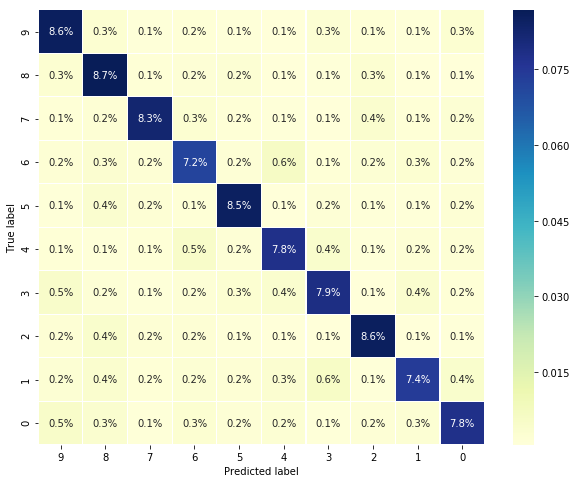

In [18]:
model_evaluation(lgbm)

I improved a lot the performance and the testing time by using the Light GBM model, but it is still computationally very expensive in training time.

I can also try to build from scratch an Artificial Neural Netrowk using Numpy

#### ANN (Numpy)

Fully Connected Layer (Linear Layer):

In [17]:
class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None        

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

Rectified Linear Activation Layer (ReLU):

In [18]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

Defining the softmax function:

In [19]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

Defining the Cross Entropy Loss:

In [20]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

Define the container NN class that enables the forward propagation and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule:

In [21]:
class NN():
    def __init__(self, lossfunc=CrossEntropy(), mode='train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

Defining the update function (SGD with momentum):

In [22]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] - learning_rate * g[i]
            p[i] += v[i]

Defining a function which gives us the minibatches (both the datapoint and the corresponding label):

In [23]:
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
        
    return minibatches

Defining the traning loop:

In [30]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)
    count_epochs=1
    Losses = []
    Accuracies = []
    Val_Losses = []
    Val_Accuracies = []

    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_train1 = []
        y_vall = []
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, : ]
            y_tr = y_train[i:i + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, : ]
            y_va = y_val[i:i + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)

        mean_train_loss = sum(loss_batch) / float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        print("Epoch: {0}/{1} \nLoss = {2} | Acc = {3}   |   Val Loss = {4} | Val Acc = {5}\n".format(count_epochs, iterations, round(mean_train_loss,3), round(train_acc,3), round(mean_val_loss,3), round(val_acc,3)))
        count_epochs+=1
        Losses.append(mean_train_loss)
        Accuracies.append(train_acc)
        Val_Losses.append(mean_val_loss)
        Val_Accuracies.append(val_acc)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(Losses)
    plt.plot(Val_Losses)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(Accuracies)
    plt.plot(Val_Accuracies)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
        
    return net, Losses, Accuracies, Val_Losses, Val_Accuracies

Checking the accuracy of the model:

In [31]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

Invocking the ANN:

Epoch: 1/100 
Loss = 2.301 | Acc = 0.1   |   Val Loss = 2.299 | Val Acc = 0.102

Epoch: 2/100 
Loss = 2.293 | Acc = 0.246   |   Val Loss = 2.281 | Val Acc = 0.248

Epoch: 3/100 
Loss = 2.246 | Acc = 0.319   |   Val Loss = 2.188 | Val Acc = 0.325

Epoch: 4/100 
Loss = 2.081 | Acc = 0.366   |   Val Loss = 1.938 | Val Acc = 0.375

Epoch: 5/100 
Loss = 1.836 | Acc = 0.481   |   Val Loss = 1.692 | Val Acc = 0.486

Epoch: 6/100 
Loss = 1.615 | Acc = 0.565   |   Val Loss = 1.494 | Val Acc = 0.568

Epoch: 7/100 
Loss = 1.436 | Acc = 0.61   |   Val Loss = 1.34 | Val Acc = 0.613

Epoch: 8/100 
Loss = 1.307 | Acc = 0.638   |   Val Loss = 1.234 | Val Acc = 0.641

Epoch: 9/100 
Loss = 1.217 | Acc = 0.657   |   Val Loss = 1.157 | Val Acc = 0.66

Epoch: 10/100 
Loss = 1.152 | Acc = 0.672   |   Val Loss = 1.091 | Val Acc = 0.674

Epoch: 11/100 
Loss = 1.103 | Acc = 0.685   |   Val Loss = 1.036 | Val Acc = 0.685

Epoch: 12/100 
Loss = 1.062 | Acc = 0.695   |   Val Loss = 0.995 | Val Acc = 0.694

Epoch:

Epoch: 100/100 
Loss = 0.435 | Acc = 0.873   |   Val Loss = 0.456 | Val Acc = 0.846



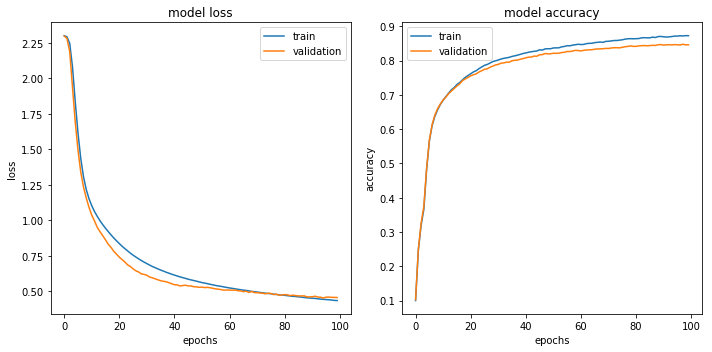

In [33]:
# input size
input_dim = X_train.shape[1]

# Renaming the testset
X_val = X_test
y_val = y_test

# hyperparameters
iterations = 100
learning_rate = 0.01
hidden_nodes = int(X_train.shape[1]/2)
output_nodes = 10

# defining neural net
nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))

nn = train(nn, 
           X_train, 
           y_train, 
           minibatch_size=200, 
           epoch=iterations,
           learning_rate=learning_rate, 
           X_val=X_val, 
           y_val=y_val)

#### ANN (Keras)

I am going to try using Keras to build the neural network. It is much more user friendly and optimized.

There are many hyperparameters that I could tune in the network:
- Number of layers
- Number of neurons in each layer
- Activation function
- Optimizer / backpropagation
- Regularization parameters
- Epochs
- Batch size
- Learning rate
- Kernel initializer
- Dropout rate

After a lot of trials, I finally found a configuration which works pretty well. I've also tried to apply BatchNormalization (commented in the code below), but the accuracy considerably decresed. For this reason, I decided to not include it in the procedure.

In [34]:
def ANN():
    # stack the layers
    network = Sequential()
    
    network.add(Dense(int(X_train.shape[1]*(4/4)), input_dim=X_train.shape[1], kernel_initializer='he_uniform'))
#     network.add(BatchNormalization())
    network.add(Activation('relu'))
    network.add(Dropout(0.1))
    
    network.add(Dense(int(X_train.shape[1]*(3/4)), kernel_initializer='he_uniform'))
#     network.add(BatchNormalization())
    network.add(Activation('relu'))
    network.add(Dropout(0.1))
    
    network.add(Dense(int(X_train.shape[1]*(2/4)), kernel_initializer='he_uniform'))
#     network.add(BatchNormalization())
    network.add(Activation('relu'))
    network.add(Dropout(0.1))
    
    network.add(Dense(int(X_train.shape[1]*(1/4)), kernel_initializer='he_uniform'))
#     network.add(BatchNormalization())
    network.add(Activation('relu'))
    network.add(Dropout(0.1))
    
    network.add(Dense(10, kernel_initializer='he_uniform'))
#     network.add(BatchNormalization())
    network.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.01)
    # compile the model
    network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return network

# Clearing any previously created sessions
keras.backend.clear_session()
  
# initialize the model object
network = ANN()

# Setting the hyperparameters
epochs=100
batch_size=1000
validation_split=0.1

# Review the network
network.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 480)               230880    
_________________________________________________________________
activation_1 (Activation)    (None, 480)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 480)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 360)               173160    
_________________________________________________________________
activation_2 (Activation)    (None, 360)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 360)               0         
________________________________________________

ANN visualization:

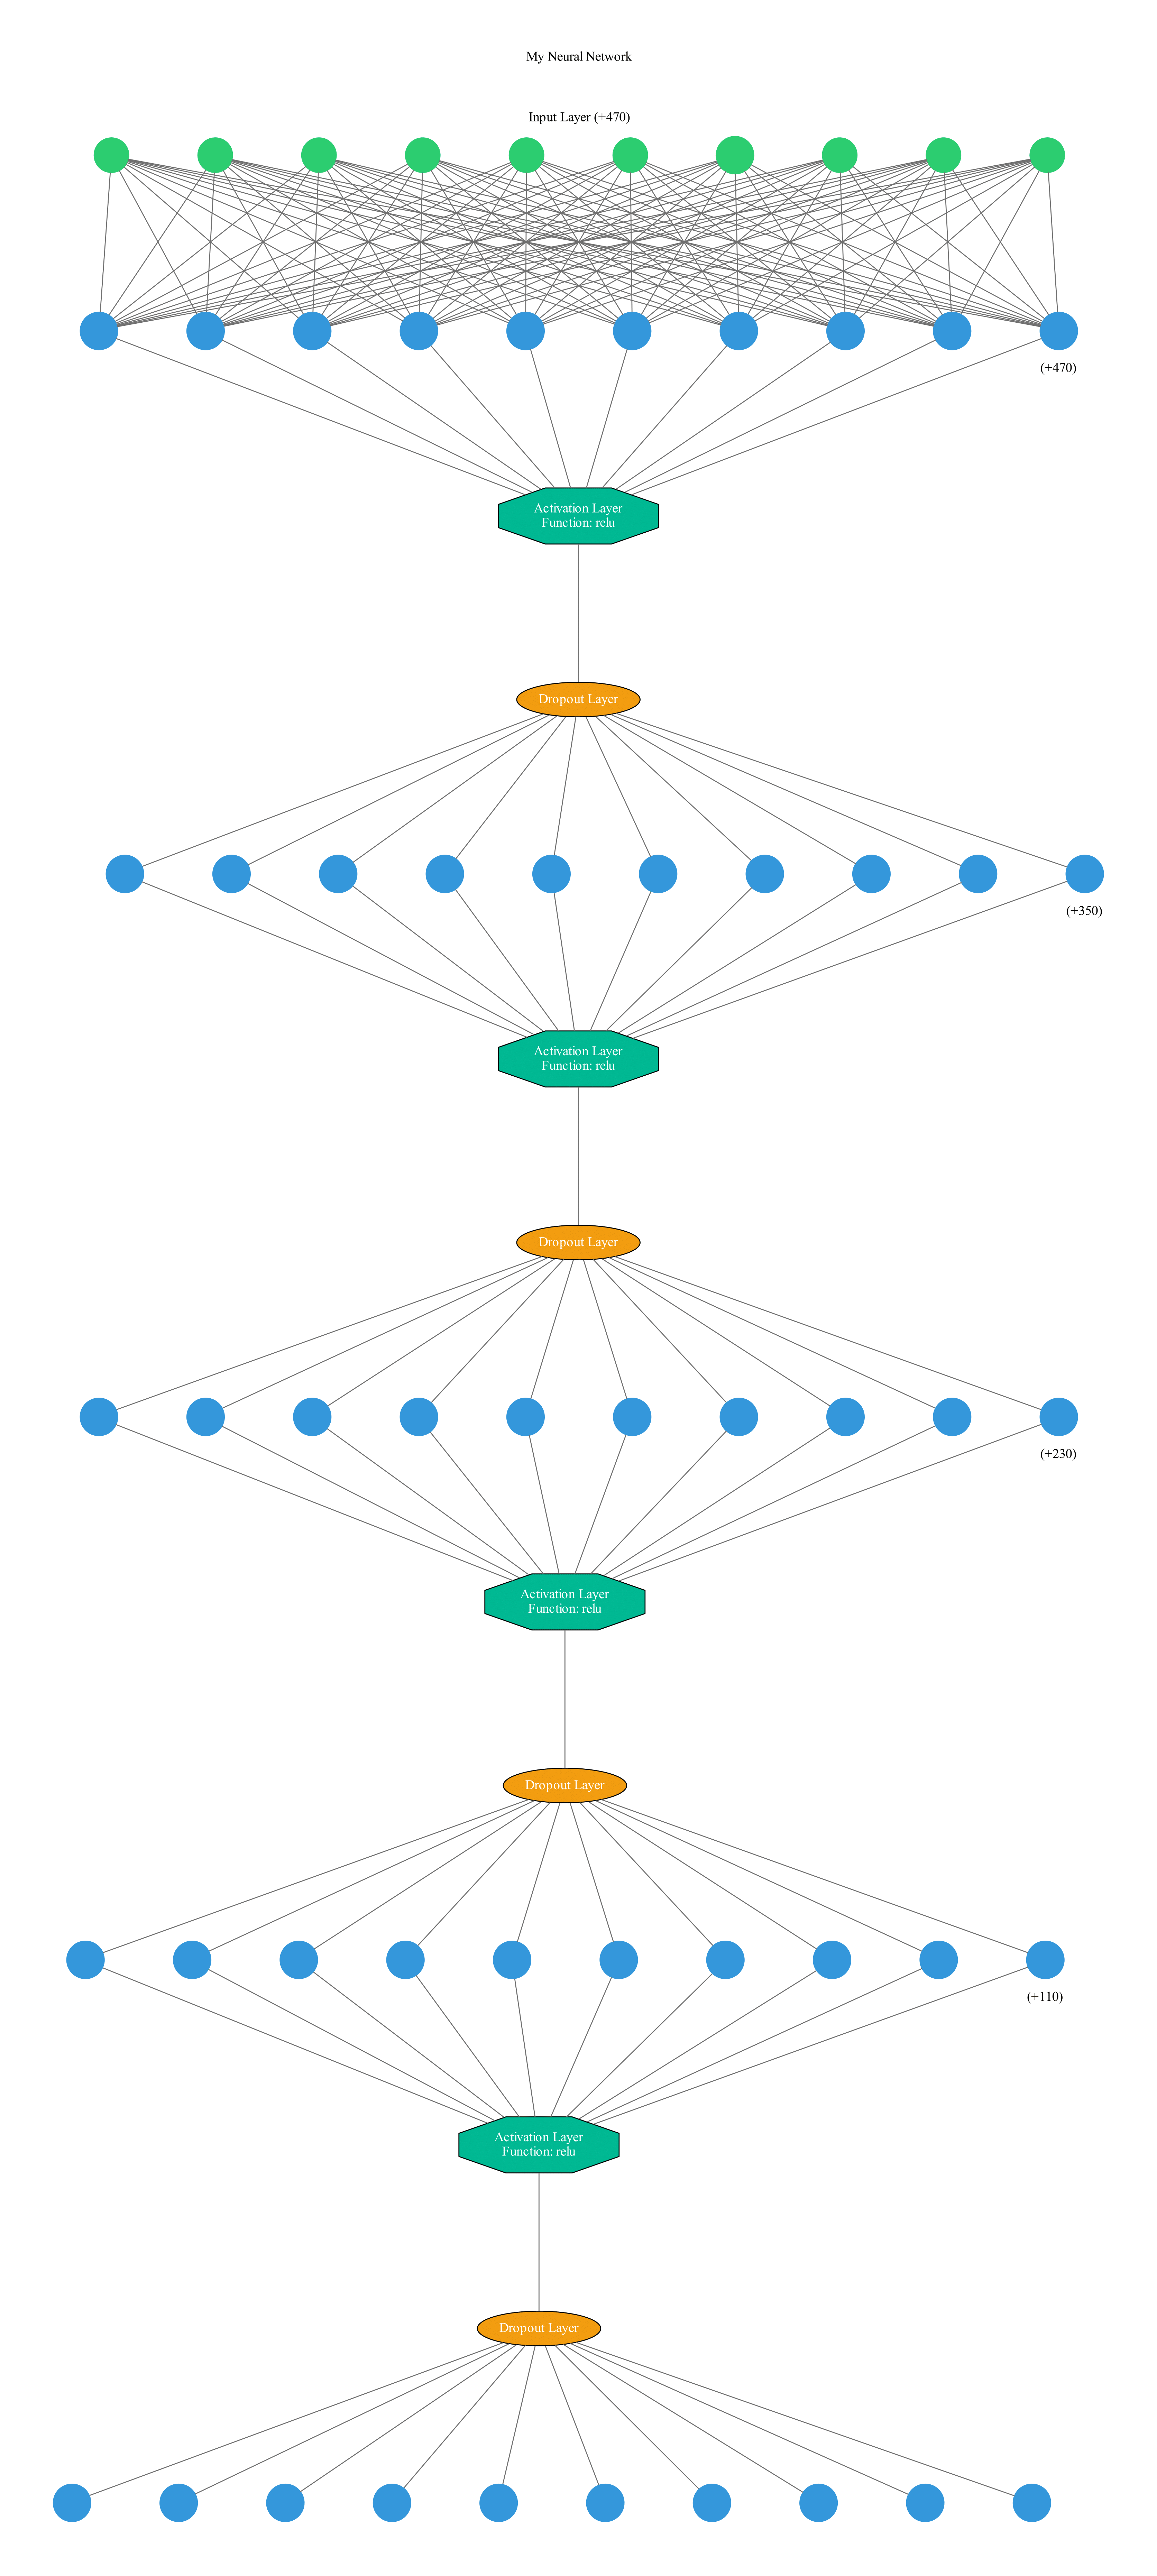

In [35]:
PATH = 'C:/Users/diego.bettega/Desktop/Machine Learning/PGP/Projects/Project 5/'

# ann_viz(network) # to produce the chart
Image(filename = PATH + 'network_image.png', width=800, height=150)

ANN training:

In [36]:
start_training=datetime.now()
history = network.fit(X_train, 
                      y_train_to_categorical, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_split=validation_split,
                      verbose=1)
stop_training=datetime.now()
execution_time_training_ANN = (stop_training-start_training).total_seconds()

Instructions for updating:
Use tf.cast instead.
Train on 37800 samples, validate on 4200 samples
Epoch 1/100
37800/37800 [==============================] - 3s 83us/step - loss: 2.3152 - accuracy: 0.1249 - val_loss: 2.2255 - val_accuracy: 0.2271
Epoch 2/100
37800/37800 [==============================] - 3s 77us/step - loss: 1.9684 - accuracy: 0.3219 - val_loss: 1.4890 - val_accuracy: 0.5307
Epoch 3/100
37800/37800 [==============================] - 3s 87us/step - loss: 1.3769 - accuracy: 0.5597 - val_loss: 1.1413 - val_accuracy: 0.6476
Epoch 4/100
37800/37800 [==============================] - 3s 80us/step - loss: 1.1361 - accuracy: 0.6433 - val_loss: 0.9706 - val_accuracy: 0.7007
Epoch 5/100
37800/37800 [==============================] - 3s 78us/step - loss: 1.0140 - accuracy: 0.6873 - val_loss: 0.8725 - val_accuracy: 0.7352
Epoch 6/100
37800/37800 [==============================] - 3s 79us/step - loss: 0.9489 - accuracy: 0.7078 - val_loss: 0.8305 - val_accuracy: 0.7450
Epoch 7/100
378

Epoch 54/100
37800/37800 [==============================] - 5s 121us/step - loss: 0.3499 - accuracy: 0.8877 - val_loss: 0.4506 - val_accuracy: 0.8638
Epoch 55/100
37800/37800 [==============================] - 4s 119us/step - loss: 0.3503 - accuracy: 0.8862 - val_loss: 0.4635 - val_accuracy: 0.8600
Epoch 56/100
37800/37800 [==============================] - 5s 125us/step - loss: 0.3460 - accuracy: 0.8888 - val_loss: 0.4488 - val_accuracy: 0.8660
Epoch 57/100
37800/37800 [==============================] - 5s 124us/step - loss: 0.3463 - accuracy: 0.8880 - val_loss: 0.4568 - val_accuracy: 0.8617
Epoch 58/100
37800/37800 [==============================] - 5s 129us/step - loss: 0.3333 - accuracy: 0.8912 - val_loss: 0.4422 - val_accuracy: 0.8645
Epoch 59/100
37800/37800 [==============================] - 5s 127us/step - loss: 0.3398 - accuracy: 0.8890 - val_loss: 0.4671 - val_accuracy: 0.8624
Epoch 60/100
37800/37800 [==============================] - 5s 141us/step - loss: 0.3348 - accuracy:

Plot the loss and accuracy in the training and validation set:

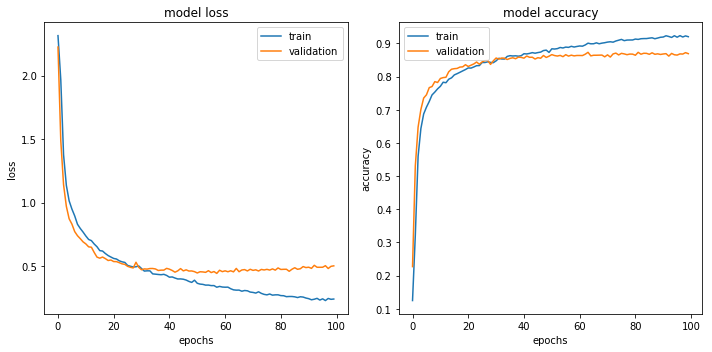

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='best')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='best')
plt.tight_layout()

ANN evaluation:

TRAINING execution time = 478.0 seconds
TESTING execution time = 2.0 seconds

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1814
           1       0.85      0.89      0.87      1828
           2       0.90      0.88      0.89      1803
           3       0.84      0.84      0.84      1719
           4       0.90      0.88      0.89      1812
           5       0.87      0.85      0.86      1768
           6       0.84      0.87      0.85      1832
           7       0.90      0.90      0.90      1808
           8       0.85      0.83      0.84      1812
           9       0.89      0.84      0.87      1804

   micro avg       0.87      0.87      0.87     18000
   macro avg       0.87      0.87      0.87     18000
weighted avg       0.87      0.87      0.87     18000



ACCURACY = 86.9 %


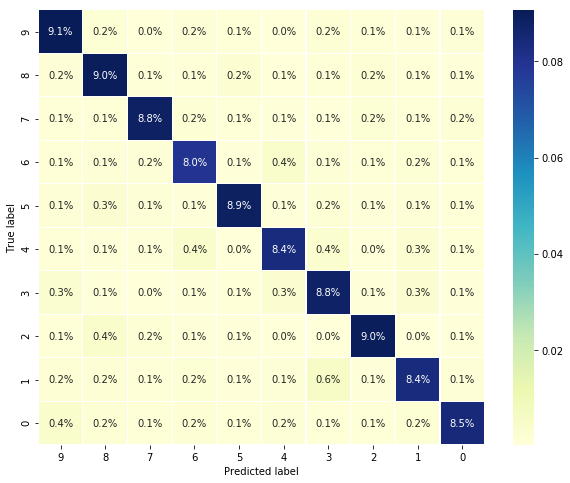

In [38]:
model_evaluation(network)

ANN outperformed both kNN and Light GBM. The accuracy is much higher (especially compared to the kNN) and the computational time is much lower (especially compared to the Light GBM model).